# Промышленность

## Исследовательский анализ данных

### Описание задачи проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Наша задача построить модель, которая предскажет температуру стали.

### Описание этапов обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Цель проекта.

Оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» построив модель которая позволит уменьшить потребление электроэнергии на этапе обработки стали за счет предсказания температуры стали.

Есть условия проекта:
* Целевая переменная target - последняя по времени температура по всей партии.
* Целевая метрика - MAE (нужно получить не более 6.8 на тесте).
* Использовать, как признак, можно только ПЕРВУЮ температуру по партии.

### Исследование данных

Загрузим данные для просмотра. Посмотрим по ним более подробную информацию через info() и распределения признаков через describe(). Там где увижу что могут быть пропуски использую isna().sum().

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
# данные об электродах;
arc=pd.read_csv('/datasets/data_arc_new.csv')
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [4]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
# данные о подаче сыпучих материалов (объём);
bulk=pd.read_csv('/datasets/data_bulk_new.csv')
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [7]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [9]:
bulk.isna().sum() # Посмотрим пропуски.

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [10]:
# данные о подаче сыпучих материалов (время);
bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv')
bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [11]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [12]:
# данные о продувке сплава газом;
gas=pd.read_csv('/datasets/data_gas_new.csv')
gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [13]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [15]:
#  результаты измерения температуры;
temp=pd.read_csv('/datasets/data_temp_new.csv')
temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [16]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [17]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Температура плавления стали находится в диапазоне от 1350 до 1535°С. При уточнении температуры плавления для нашей марки стали температура 1500 градусов. Поэтому ниже 1500 градусов будет анамалией.

In [18]:
# Подсчет количества значений менее 1500 градусов
temp_count = temp[temp['Температура'] < 1500]['Температура'].count()

print('Количество значений менее 1500 градусов:', temp_count)

Количество значений менее 1500 градусов: 5


In [19]:
temp.isna().sum() # Посмотрим пропуски.

key                0
Время замера       0
Температура     3427
dtype: int64

In [20]:
#  данные о проволочных материалах (объём);
wire=pd.read_csv('/datasets/data_wire_new.csv')
wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [22]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [23]:
wire.isna().sum() # Посмотрим пропуски.

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [24]:
# данные о проволочных материалах (время);
wire_time =pd.read_csv('/datasets/data_wire_time_new.csv')
wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Выводы

Загрузили данные для просмотра. Посмотрим по ним более подробную информацию через info() и распределения признаков через describe(). Увидев места где могут быть пропуски использую isna().sum(). Посмотрел количество значений с аномально низкой температурой.

В предложенных датосетах имеются недоработки. Как и аномальные значения противоречащие технологическому процессу так и множество пропусков. Имеются датосеты которые нам не помогут в построении модели. Данные требуется предобработать, а после обедиить в один датасет по которому мы и будем делать модель.

### Список уточняющих вопросов.

1. Если после удаления ключей без замеров или с 1 замером в результаты измерения температуры остольные пропуски можно привести к средней температуре.*


2. Правельно ли я заплонировал предобработку в каждом датасети.
* data_arc_new.csv — данные об электродах; удалю аномалии (отрицательные значения).
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём); - Пропуски заменить 0
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);- небуду использовать
* data_gas_new.csv — данные о продувке сплава газом; использую в полном обеме.

* data_temp_new.csv — результаты измерения температуры; * и удалю аномалии (менее 1500 градусов).

* data_wire_new.csv — данные о проволочных материалах (объём); - Пропуски заменить 0

* data_wire_time_new.csv — данные о проволочных материалах (время). - небуду использовать

### Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.

1. Предобработка данных: Изучив данные удалим анамалии и заполним пропуски в данных. 

2. Объединение данных: Поскольку у нас есть несколько файлов с данными, содержащих информацию о разных аспектах процесса, можем объединить эти данные в одну таблицу, используя столбец "key" как ключ для объединения.

3. Изучение связей между переменными: Посмотрите на корреляции между различными переменными в ваших данных. Например можем проверить, как активная и реактивная мощности связаны с другими параметрами процесса.

4. Построение моделей: На основе проведенного анализа приступим к построению моделей для прогнозирования. Обучим модель на имеющихся данных, используя подходящие методы разделения данных на обучающую и тестовую выборки, а затем оценим производительность модели на тестовых данных.

## Решения задачи.

### Предобработка данных

Данные о мощности электродов

В data_arc_new.csv — данные об электродах есть отрицательное значение в реактивной мощности – нужно удалить этот ключ целиком.

In [26]:
arc_count = arc[arc['Реактивная мощность'] < 0]['Реактивная мощность'].count()

print('Реактивная мощность с отрицательным значением:', arc_count)

Реактивная мощность с отрицательным значением: 1


In [27]:
arc = arc[arc['Реактивная мощность'] > 0]

Данные по началу и концу нагрева надо либо удалить либо сгенерирвать новый признак.

In [28]:
# Удаление столбцов "Начало нагрева дугой" и "Конец нагрева дугой"
# aggregated_arc = arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
# aggregated_arc

In [29]:
# Переведен в необходимый формат.
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S.%f')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S.%f')

In [30]:
# Создадим переменную Время нагрева, которая будет отображать время нагрева
arc['Время нагрева (сек)'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']

In [31]:
# Переведем Время нагрева в цифровое значение (секунды), чтобы сделать факторный анализ
arc['Время нагрева (сек)'] = arc['Время нагрева (сек)'].dt.seconds

In [32]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева (сек)
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


In [33]:
aggregated_arc = arc.groupby('key').sum()

aggregated_arc

,Активная мощность,Реактивная мощность,Время нагрева (сек)
key,,,
1,3.036730,2.142821,1098
2,2.139408,1.453357,811
3,4.063641,2.937457,655
4,2.706489,2.056992,741
5,2.252950,1.687991,869
...,...,...,...
3237,2.541872,2.025417,909
3238,1.374821,1.038103,546
3239,4.848005,3.541541,1216


Данные об объеме сыпучих и проволочных материалов частично пропущены, выдали информацию, что пропуск это отсутствие добавления материалов поэтому их можем заменить 0 значения. А время их подачи мы использовать небудем.

In [34]:
# Замена пропущенных значений на нули
bulk = bulk.fillna(0)
# Вывод обновленного bulk
print(bulk)

       key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1        2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2        3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3        4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4        5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     0.0     0.0   170.0     0.0     0.0     0.0     0.0     0.0   
3125  3238     0.0     0.0   126.0     0.0     0.0     0.0     0.0     0.0   
3126  3239     0.0     0.0     0.0     0.0     0.0   114.0     0.0     0.0   
3127  3240     0.0     0.0     0.0     0.0     0.0    26.0     0.0     0.0   
3128  3241     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk

In [35]:
# Замена пропущенных значений на нули
wire= wire.fillna(0)
# Вывод обновленного wire
print(wire)

       key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3      

Ранее у нас была анамалия с температурой нижу 1500 градусов, удалим такие значения.

In [36]:
temp = temp[temp['Температура'] > 1500]

In [37]:
print(temp)

        key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
18061  3237  2019-09-06 11:31:15       1569.0
18067  3238  2019-09-06 12:16:15       1584.0
18071  3239  2019-09-06 14:16:50       1598.0
18080  3240  2019-09-06 15:25:21       1617.0
18086  3241  2019-09-06 16:48:55       1586.0

[14660 rows x 3 columns]


После вопросов о температуре получили ответ: data_temp_new.csv — Партии, для которых не все замеры температуры известны следует удалить (т.к. если удалить только замеры, а не полные партии, измерения качества будут завышены). Разобъем 

In [38]:
unique_keys = temp['key'].unique()  # Получаем уникальные значения столбца 'key'

for key in unique_keys:
    subset_df = temp[temp['key'] == key]  # Получаем подмножество данных для текущего значения 'key'
    
    if subset_df['Время замера'].isnull().any():  # Проверяем наличие пропусков в столбце 'Время замера'
        temp = temp[temp['key'] != key]  # Удаляем строки с соответствующим значением 'key'

print(temp)

        key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
18061  3237  2019-09-06 11:31:15       1569.0
18067  3238  2019-09-06 12:16:15       1584.0
18071  3239  2019-09-06 14:16:50       1598.0
18080  3240  2019-09-06 15:25:21       1617.0
18086  3241  2019-09-06 16:48:55       1586.0

[14660 rows x 3 columns]


In [39]:
key_counts = temp['key'].value_counts()  # Подсчет количества значений 'Температура' для каждого ключа

keys_to_remove = key_counts[key_counts < 2].index  # Получение ключей, у которых меньше двух значений

temp = temp[~temp['key'].isin(keys_to_remove)]  # Удаление строк с соответствующими ключами

print(temp)

        key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
13921  2499  2019-08-10 13:33:21       1569.0
13922  2499  2019-08-10 13:41:34       1604.0
13923  2499  2019-08-10 13:46:28       1593.0
13924  2499  2019-08-10 13:54:56       1588.0
13925  2499  2019-08-10 13:58:58       1603.0

[13920 rows x 3 columns]


В ходи вебинара также выяснили что нас интерисует только два значения температуры. Первая температура нужна для обучения температуры. Последняя температура является целевым признаком.

In [40]:
temp = temp.groupby(by ='key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.columns = ['key', 'Время замера 1', 'Время замера 2','Температура 1','Температура 2']
temp = temp[['key','Температура 1','Температура 2']]
temp

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


### Объединение данных

При объединении данных по ключу используем только INNER.

In [41]:
# При объединии данные в одну таблицу, используем столбец "key" как ключ для объединения
data = (temp.merge(aggregated_arc, how='inner', on = 'key').merge(wire, how='inner', 
on = 'key').merge(bulk, how='inner', on = 'key').merge(gas, how='inner', on = 'key'))

In [42]:
data.tail()

,key,Температура 1,Температура 2,Активная мощность,Реактивная мощность,Время нагрева (сек),Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
2324,2495,1570.0,1591.0,3.168133,2.210936,723,89.150879,0.00000,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,4.174918,2.872031,940,114.179527,0.00000,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,3.605239,2.452092,569,94.086723,9.04800,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,3.202310,2.239820,750,118.110717,0.00000,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657
2328,2499,1569.0,1603.0,1.737084,1.296836,883,110.160958,50.00528,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,11.336151


In [43]:
data = data.drop('key', axis=1)

In [44]:
print('Количество строк', data.shape[0])
print('Количество столбцов', data.shape[1])

Количество строк 2329
Количество столбцов 30


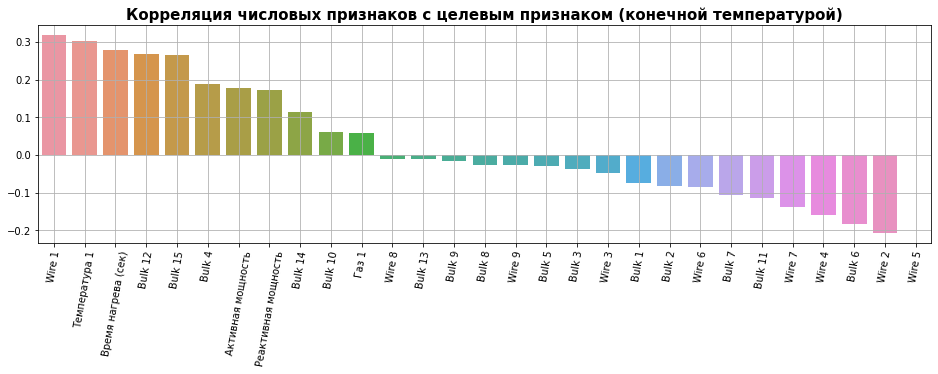

In [45]:
corr_target=pd.Series()
for col in data.columns:
    corr_target[col] = data['Температура 2'].corr(data[col])
corr_target= corr_target.sort_values(ascending=False)[1:]
plt.figure(figsize=(16,4))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.grid()
plt.xticks(rotation=80)
plt.title("Корреляция числовых признаков с целевым признаком (конечной температурой)", weight='bold', fontsize=15)
plt.show();

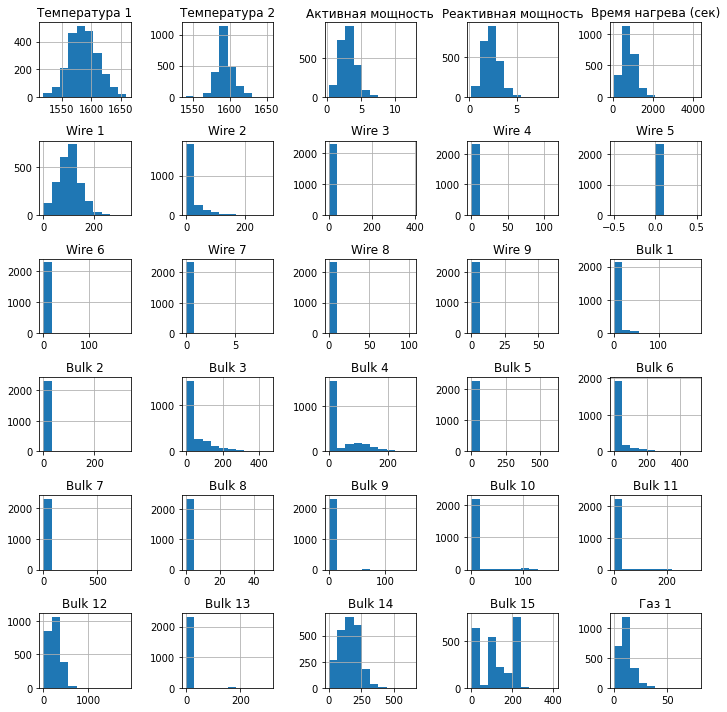

In [46]:
data.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

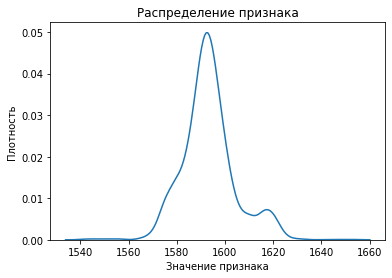

In [47]:
# Построение графика плотности для целевого признака 'Температура 2'
sns.kdeplot(data['Температура 2'])
plt.xlabel('Значение признака')
plt.ylabel('Плотность')
plt.title('Распределение признака')
plt.show()

### Изучение связей между переменными

Выведим матрицу корреляций в виде тепловой карты heatmap.

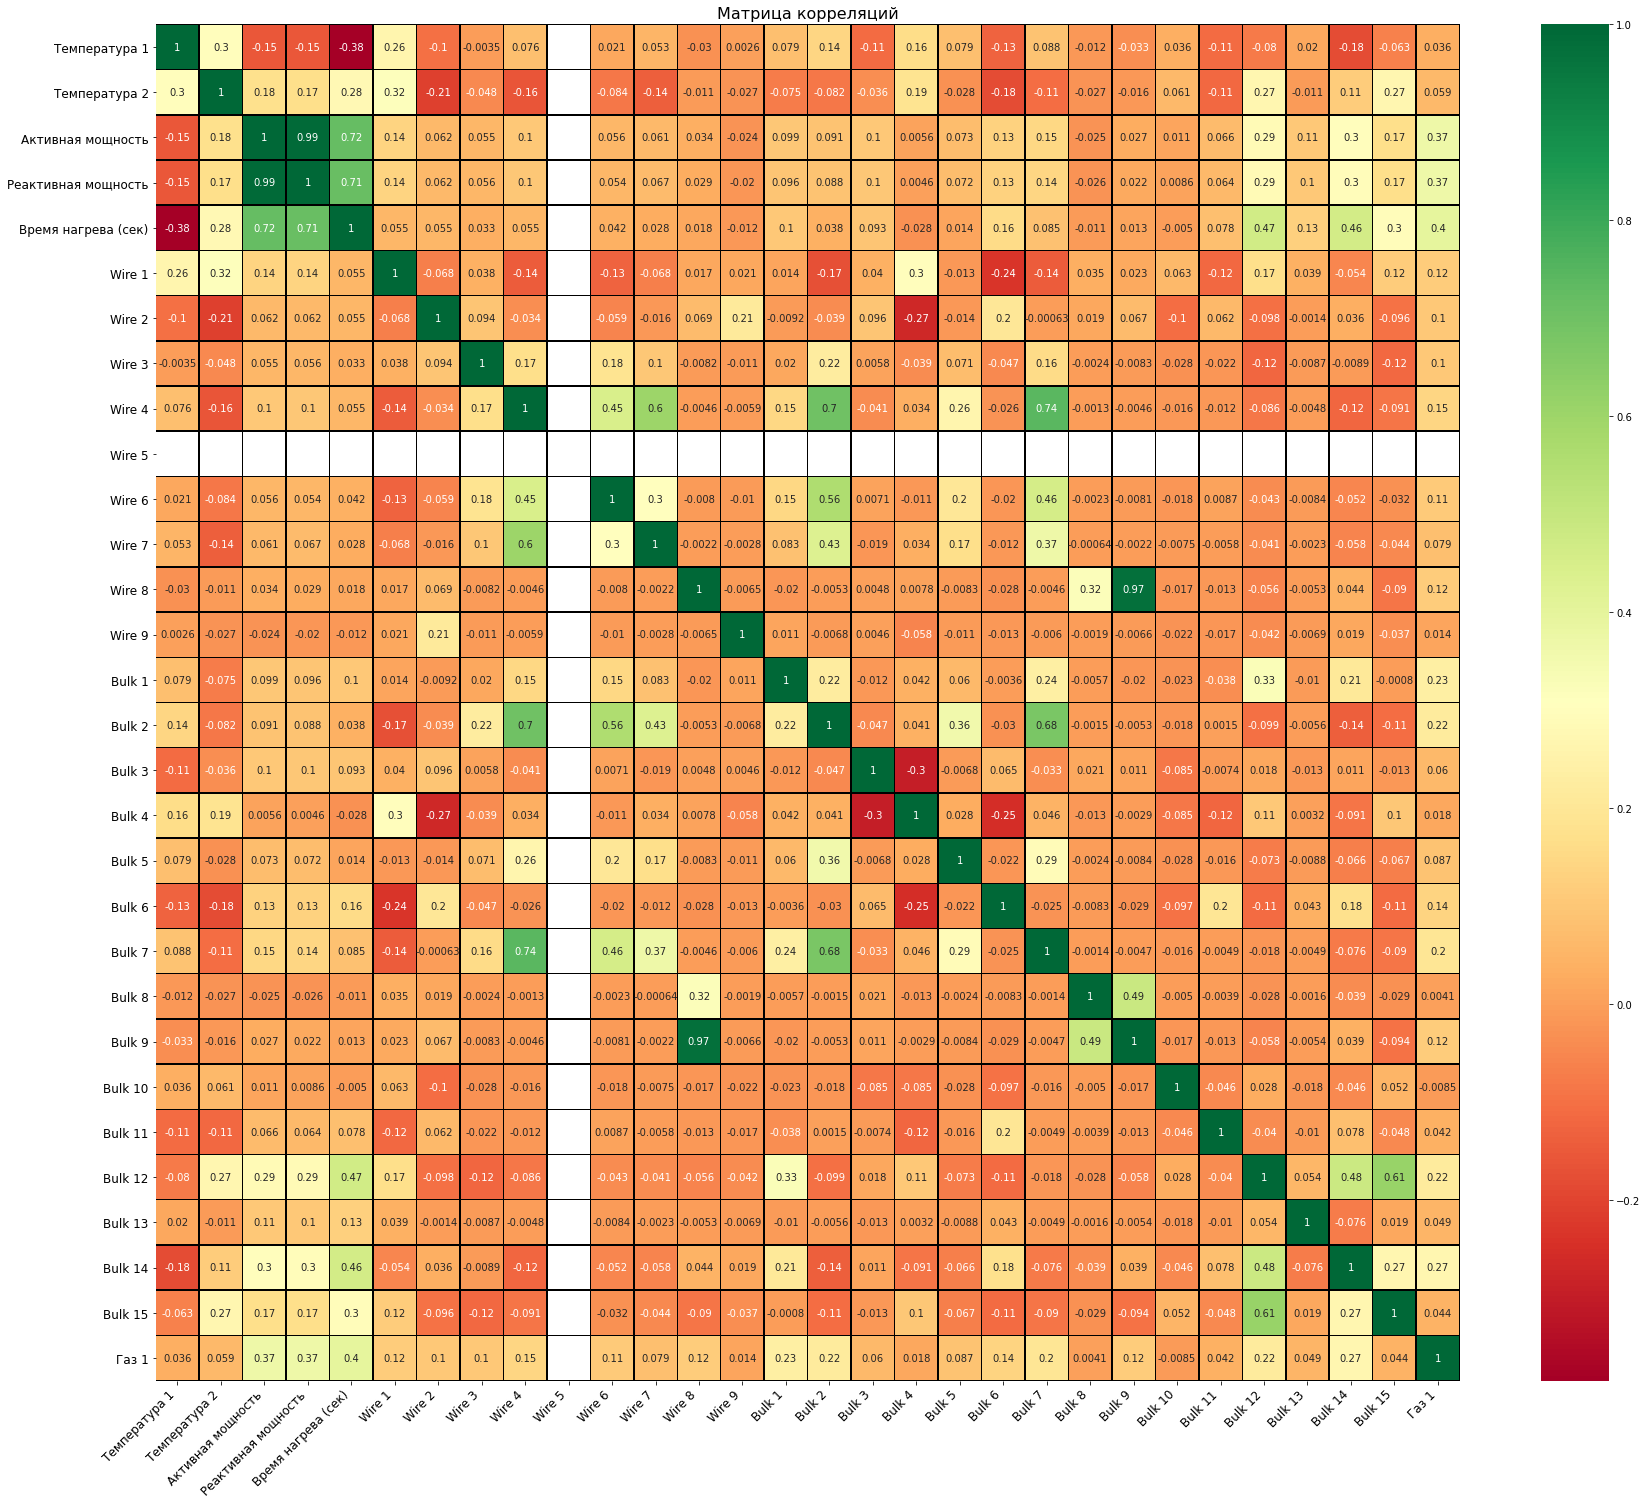

In [48]:
# Вычислить матрицу корреляций
correlation_matrix = data.corr()

# Создать тепловую карту
plt.figure(figsize=(25, 21))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", linewidths=0.5, linecolor='black')

# Настроить параметры отображения
plt.title('Матрица корреляций', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Показать тепловую карту
plt.show()

In [49]:
# Для удобства выведим сильные кореляции между разными переменными.
data.corr().unstack()[(data.corr().unstack() < 1) & (abs(data.corr().unstack()) > 0.7)]

Активная мощность    Реактивная мощность    0.992424
                     Время нагрева (сек)    0.721249
Реактивная мощность  Активная мощность      0.992424
                     Время нагрева (сек)    0.713422
Время нагрева (сек)  Активная мощность      0.721249
                     Реактивная мощность    0.713422
Wire 4               Bulk 7                 0.740572
Wire 8               Bulk 9                 0.974969
Bulk 7               Wire 4                 0.740572
Bulk 9               Wire 8                 0.974969
dtype: float64

### Построение моделей

На основе проведенного анализа приступим к построению моделей для прогнозирования. Обучим модель на имеющихся данных, используя подходящие методы разделения данных на обучающую и тестовую выборки, а затем оценим производительность модели на тестовых данных.

Вначале разделим данные на кросс-валидацию отводим 75% данных, на тест 25 % данных, выводим уразмеры полученных выборок

In [50]:
# Разделение данных на обучающую и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(
    data.drop(['Температура 2'], axis=1), 
    data['Температура 2'], # Целевой признак - конечная температура ('Температура 2')
    test_size=0.25, # Вывод размеров обучающей и тестовой выборок
    random_state=190623)
feature_names = list(data.drop(['Температура 2'], axis=1).columns) # Создаем список имен признаков без целевого признака

In [51]:
# Вывод размеров выборок
print("Размер обучающей выборки:", train_features.shape[0])
print("Размер тестовой выборки:", test_features.shape[0])

Размер обучающей выборки: 1746
Размер тестовой выборки: 583


In [52]:
# Масштабирование признаков
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

CatBoostRegressor

In [53]:
# Создание модели CatBoostRegressor
catboost_model = CatBoostRegressor(random_state=190623, verbose=False)
# Обучение модели CatBoostRegressor на обучающей выборке
catboost_model.fit(train_features, train_target)

RandomForestRegressor

In [54]:
# Создание модели RandomForestRegressor
rf_model = RandomForestRegressor(random_state=190623)
# Обучение модели RandomForestRegressor на обучающей выборке
rf_model.fit(train_features, train_target)

RandomForestRegressor(random_state=190623)

### Выбор моделей

In [55]:
# Оценка лучшей модели RandomForestRegressor на кросс-валидации
rf_cross_val_score = cross_val_score(rf_model, train_features, train_target, scoring='neg_mean_absolute_error').mean()

# Оценка лучшей модели CatBoostRegressor на кросс-валидации
catboost_cross_val_score = cross_val_score(catboost_model, train_features,
        train_target, scoring='neg_mean_absolute_error').mean()

In [56]:
# Вывод оценки лучшей модели RandomForestRegressor на кросс-валидации
print("Оценка лучшей модели RandomForestRegressor на кросс-валидации (MAE):", -1 * rf_cross_val_score)

# Вывод оценки лучшей модели CatBoostRegressor на кросс-валид
print("Оценка лучшей модели CatBoostRegressor на кросс-валидации (MAE):", -1 * catboost_cross_val_score)

Оценка лучшей модели RandomForestRegressor на кросс-валидации (MAE): 6.211829144494476
Оценка лучшей модели CatBoostRegressor на кросс-валидации (MAE): 6.213964294747514


In [57]:
# Предсказание на обучающей выборке
train_predictions_rf = rf_model.predict(train_features)

# Расчет R2
rf_r2_с= r2_score(train_target, train_predictions_rf)

In [58]:
# Предсказание на обучающей выборке
train_predictions_catboost = catboost_model.predict(train_features)

# Расчет R2
catboost_r2_с = r2_score(train_target, train_predictions_catboost)

In [59]:
# Вывод оценки R2 RandomForestRegressor на кросс-валидации
print("Оценка R2 RandomForestRegressor на кросс-валидации:", rf_r2_с)

# Вывод оценки R2 CatBoostRegressor на кросс-валид
print("Оценка R2 CatBoostRegressor на кросс-валидации:", catboost_r2_с)

Оценка R2 RandomForestRegressor на кросс-валидации: 0.9175863900625456
Оценка R2 CatBoostRegressor на кросс-валидации: 0.8804714301567214


Обе модели объясняют вариацию целевого признака лучше чем его простое среднее значение.

In [60]:
# Создание константной модели DummyRegressor
dummy_model = DummyRegressor()
dummy_model.fit(train_features, train_target)

# Оценка константной модели DummyRegressor на тестовой выборке
dummy_score = dummy_model.score(test_features, test_target)

In [61]:
# Предсказание целевого признака с помощью константной модели
dummy_predictions = dummy_model.predict(test_features)

# Расчет MAE для константной модели
dummy_mae = mean_absolute_error(test_target, dummy_predictions)


In [62]:
# Вывод метрик MAE для dummy_model
print("MAE для dummy_model на тестовой выборке:", dummy_mae)

MAE для dummy_model на тестовой выборке: 7.960433944580989


In [63]:
# Вывод оценки константной модели DummyRegressor на тестовой выборке
print("Оценка константной модели DummyRegressor на тестовой выборке (R2):", dummy_score)

Оценка константной модели DummyRegressor на тестовой выборке (R2): -0.0015534633465237313


In [64]:
# Определение наборов гиперпараметров
param_grid = {
    'max_depth': [None, 10, 20],  # Пример набора значений для max_depth
    'min_samples_leaf': [1, 2, 5]  # Пример набора значений для min_samples_leaf
}

# Создание модели RandomForestRegressor
rf_model_g = RandomForestRegressor(random_state=190623)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_absolute_error')

# Обучение модели на обучающей выборке
grid_search.fit(train_features, train_target)

# Вывод лучших значения гиперпараметров
print("Лучшие значения гиперпараметров:", grid_search.best_params_)

# Получение лучшей модели с лучшими значениями гиперпараметров
best_model = grid_search.best_estimator_

# Обучение лучшей модели на обучающей выборке
best_model.fit(train_features, train_target)

Лучшие значения гиперпараметров: {'max_depth': None, 'min_samples_leaf': 1}


RandomForestRegressor(random_state=190623)

In [65]:
# Предсказание на тестовой выборке
predictions = best_model.predict(test_features)

# Расчет MAE
mae = mean_absolute_error(test_target, predictions)
print("MAE на тестовой выборке:", mae)

# Расчет R2
r2 = r2_score(test_target, predictions)
print("R2 на тестовой выборке:", r2)

MAE на тестовой выборке: 6.331886792452833
R2 на тестовой выборке: 0.3215748668899274


### Исследуем важность признаков

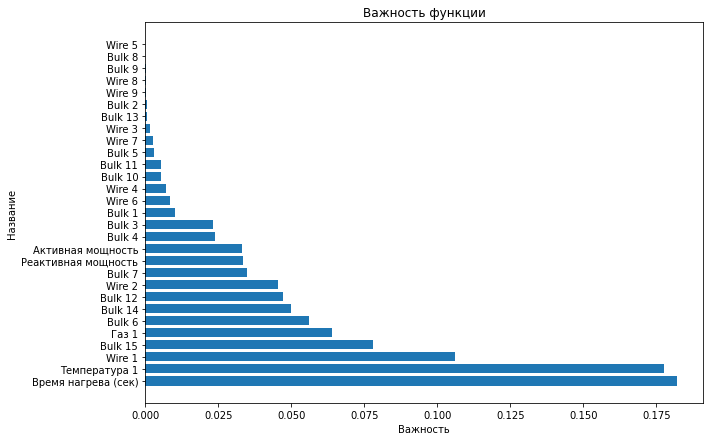

                Feature    Importance
3   Время нагрева (сек)  1.818964e-01
0         Температура 1  1.776510e-01
4                Wire 1  1.059378e-01
27              Bulk 15  7.796508e-02
28                Газ 1  6.401914e-02
18               Bulk 6  5.621452e-02
26              Bulk 14  4.980397e-02
24              Bulk 12  4.717011e-02
5                Wire 2  4.529836e-02
19               Bulk 7  3.486223e-02
2   Реактивная мощность  3.343362e-02
1     Активная мощность  3.296983e-02
16               Bulk 4  2.382171e-02
15               Bulk 3  2.309909e-02
13               Bulk 1  1.016881e-02
9                Wire 6  8.559403e-03
7                Wire 4  7.032289e-03
22              Bulk 10  5.358676e-03
23              Bulk 11  5.283316e-03
17               Bulk 5  3.067724e-03
10               Wire 7  2.708441e-03
6                Wire 3  1.757049e-03
25              Bulk 13  7.350141e-04
14               Bulk 2  6.866314e-04
12               Wire 9  2.090790e-04
11          

In [66]:
# Получение важности признаков
importances = rf_model.feature_importances_

# Создание DataFrame с важностью признаков
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Сортировка по убыванию важности
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Построение графика важности признаков
plt.figure(figsize=(10, 7))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Важность')
plt.ylabel('Название')
plt.title('Важность функции')
plt.show()

# Вывод таблицы с важностью признаков
print(feature_importances)

Одим из наиболее сильных признаков окозалось время нагрева которое мы получили дополнительно для улучшения модели. Начальная температура как и ожидалось является одной из самых значимых фичей. А вот мощьность оказалась не столь значимой кая я изночально думал. 

### Выводы

Предобработали данные убрав аномалии и пропуски. Мы получили дополнительную фичу (время нагрева в секундах), для улучшения модели. Обеденили данные. Была сделана предобработка данных и по просьбе заказчика выведена матрица кореляций. Мы взяли модель случайного леса и градиентного бустинга. Их МАЕ незначительно отличаются, но немного лучше оказался случайный лес. Поскольку наша модель удовлетворяет запросу в МАЕ на тесте <= 6.8 то и подбор гипер параметров делать небудем поскольку это увеличит время обработки работы. Работа выполнялась по предворительному плану с учотом пожелания заказчика.

## Отчёт по решению

Было выдано задание оптимизировать производственные расходы, металлургического комбината ООО «Так закаляем сталь» за счет уменьшения потребления электроэнергии на этапе обработки стали. Наша задача построить модель, которая предскажет температуру стали. 

У тимлида уточнили, что Целевая переменная target - последняя по времени температура по всей партии. Целевая метрика - MAE (нужно получить не более 6.8 на тесте). Использовать, как признак, можно только первую температуру по партии. Перед нами не стоит задача временного ряда. Также заказчик просит дополнительно с основной метрикой MAE рассчитывать еще и метрику R2.  

### сравнение решения и плана

Нам дали описание этапов обработки и несколько датосетов с данными. Посмотрев все данные были выявлены аномалии, пропуски и найдены данные которые не получится использовать в модели. После изучения был предложен и согласован план работы. Он состоял из 4 пунктов и  был выполнен.

#### Предобработка данных: 

План:  Изучив данные удалим анамалии и заполним пропуски в данных.

Решение: Были и уточнение от заказчика по поводу предобработки данных: ключи только с одним замером мы удаляем по температуре, но не по мощности, т.к. в данных по мощности может быть и одно значение на весь ключ, но при этом иметься несколько замеров температуры. Если обнаружим ключи, где первая температура равна последней - это нормально, удалять такие ключи не нужно. Из данных об электродах удалили отрицательное значение в реактивной мощности. Таблицы о времени подачи в итоговую таблицу не идут. В данных о проволочных и сыпучих материалов пропуски заменили нулями поскольку отсутствие данных обозначает, что они не использовались. Температура плавления стали обычно в диапазоне примерно до 1500 градусов, поэтому температуру ниже этого диапазона удалили. Мы добавили признак время нагрева который получили путем вычисления начала и конца времени нагрева.

####  Объединение данных: 

План: Поскольку у нас есть несколько файлов с данными, содержащих информацию о разных аспектах процесса, можем объединить эти данные в одну таблицу, используя столбец "key" как ключ для объединения.

Решение: При объединении данные в одну таблицу, использовался столбец "key" как ключ для объединения при этом были агрегированы данные в тех таблицах, где для одной партии имеются несколько итераций. Агрегировали данные по Inner взяли только те ключи, которые есть во всех датафреймах. 

####  Изучение связей между переменными: 

План: Посмотрите на корреляции между различными переменными в ваших данных. Например можем проверить, как активная и реактивная мощности связаны с другими параметрами процесса.

Решение: После объединения вывели график распределения признаков и удалили key. По требованию заказчика выводим матрицу корреляций в виде тепловой карты heatmap. Посмотрели какие связи имеют высокую взаимосвязь.

#### Построение моделей: 

План: На основе проведенного анализа приступим к построению моделей для прогнозирования. Обучим модель на имеющихся данных, используя подходящие методы разделения данных на обучающую и тестовую выборки, а затем оценим производительность модели на тестовых данных.

Решение: На основе проведенного анализа приступили к построению моделей для прогнозирования. Разделили данные на обучающую 75% и тестовую 25% выборки. Получили размер обучающий 1746 и тестовой 583 выборки. Провели масштабирование признаков. Затем оценили производительность модели на тестовых данных. Создали модели RandomForestRegressor и CatBoostRegressor бучили их. Оценили их на кросс-валидации. Лучше себя показала RandomForestRegressor. Далее последовало создание и оценка константной модели DummyRegressor. Вывели лучшую модель с гиперпараметрами и  сделали предсказание лучшей модели RandomForestRegressor на тестовой выборке. МАЕ на тесте показало < 6.8 как и требовал заказчик. После исследовали важность признаков. Все шаги нашего плана и требования заказчика были выполнены. 

### описание трудностей проекта и как они были решены

Основной трудностью проекта составила добавление нового признака поскольку потребовала многоступенчатого подхода. Во-первых пришлось перевести дату к нужному формату, далее вычел одно время из другого узнав сколько секунд длился нагрев. После чего снова изменить формат и интегрировать в общую таблицу.

### описание ключевых шагов решения

Вначале изучили данные и требования заказчика. Выяснили интересующие нас вещи. Предобработали данные. Обединили таблицы. Посмотрели связь между переменными. Попробовали пару моделий и выбрали лучшую. Посмотрели важность признаков.

### признаки, которые использовали для обучения Итоговой модели и как они предобрабатывались

Были даны 7 файлов с различными данными.

* data_arc_new.csv — данные об электродах; удалю аномалии (отрицательные значения). Из данных по началу и концу нагрева  сгенерирвали новый признак. В итоги получили из данного дата сета следующии признаки: Активная мощность, Реактивная мощность, Время нагрева (сек).

* data_bulk_new.csv — данные о подаче сыпучих материалов (объём); - Пропуски заменить 0. Признаки от Bulk 1 до Bulk 15.

* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);- небуду использовать. 

* data_gas_new.csv — данные о продувке сплава газом; использую в полном обеме. Признак Газ 1

* data_temp_new.csv — результаты измерения температуры; Удалю аномалии (менее 1500 градусов). После удаляю с 1 значением температуры. Разделяю на первую и последнюю температуру (целевой признак). Признаки Температура 1,	Температура 2 -будет целевым признаком.

* data_wire_new.csv — данные о проволочных материалах (объём); - Пропуски заменить 0. Признаки от Wire 1 до Wire 9.

* data_wire_time_new.csv — данные о проволочных материалах (время). - небуду использовать

* Обший датасет делали с помощью столбца key который после обединения удалили.

### описание Итоговой модели

Лучшей моделью оказалась RandomForestRegressor с (MAE): 6.211829144494476 на кросс-валидации. к этой модели подобрали гиперпораметры (Лучшие значения гиперпараметров: {'max_depth': None, 'min_samples_leaf': 1}), ее random_state=190623. Далее лучшую модель проверили на тестовой выборки ее МАЕ = 6.331886792452833, а R2=0.3215748668899274. Таким образом для ООО «Так закаляем сталь» построили модель, которая предсказывает температуру стали. 